# package test 6 (full 0809:) everything is based on raftup_env

In [1]:
import numpy as np
from raftup import (
    _downsample,
    _fsgw_utils,
    _metrics_two_gpr,
    _load_data,
    _plot,
    _recoverfull_new_new_knn
)

/opt/anaconda3/envs/raftup_env/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/anaconda3/envs/raftup_env/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


/Users/salovjade/Library/CloudStorage/Dropbox/raftup_repo/src/raftup/_load_data.py:12: FutureWarning: Use `squidpy.read.visium` instead.
  ad = sc.read_visium(path=os.path.join(root_dir, section_id), count_file=section_id+'_filtered_feature_bc_matrix.h5')
/opt/anaconda3/envs/raftup_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/raftup_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/salovjade/Library/CloudStorage/Dropbox/raftup_repo/src/raftup/_load_data.py:12: FutureWarning: Use `squidpy.read.visium` instead.
  ad = sc.read_visium(path=os.path.join(root_dir, section_id), count_file=section_id+'_filtered_feature_bc_matrix.h5')
/opt/anaconda3/envs/raftup_env/lib/pytho

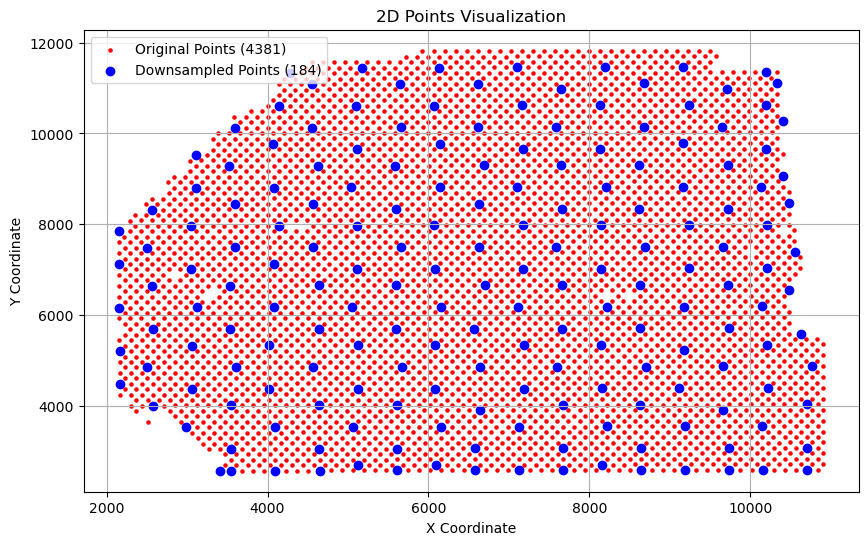

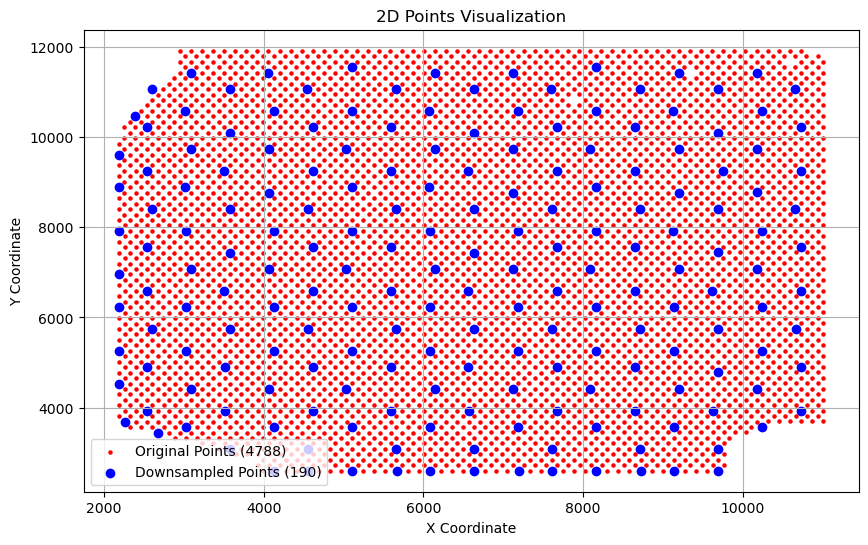

In [2]:
section_ids_list = [['151508', '151509']]
pair = "151508_151509"


for section_ids in section_ids_list:
    dataset = section_ids[0] + '_' + section_ids[1]

    sliceA = _load_data.load_DLPFC(section_id=section_ids[0])
    sliceB = _load_data.load_DLPFC(section_id=section_ids[1])

random_state = 23
np.random.seed(random_state)
tar_distance = 1020

downsampled_sliceA,indices_dsa = _downsample.downsample_slice(sliceA, tar_distance)
_downsample.visualize_downsampled_points(sliceA, downsampled_sliceA)

downsampled_sliceA.write("ds_08.h5ad")

downsampled_sliceB,indices_dsb = _downsample.downsample_slice(sliceB, tar_distance)
_downsample.visualize_downsampled_points(sliceB, downsampled_sliceB)

downsampled_sliceB.write("ds_09.h5ad")

test_label = np.concatenate((np.array(downsampled_sliceA.obs['original_clusters']),np.array(downsampled_sliceB.obs['original_clusters'])),axis=0)
XA = downsampled_sliceA.obsm['spatial']
XB = downsampled_sliceB.obsm['spatial']

In [3]:
np.save(f"align_data/{pair}_downsample_indices_dsa.npy", indices_dsa)
np.save(f"align_data/{pair}_downsample_indices_dsb.npy", indices_dsb)


In [4]:
from scipy.spatial import distance

file_path = f"/Users/salovjade/Library/CloudStorage/Dropbox/RAFTUP_after0320/DLPFC12/download_from_remote_server/feature_{pair}_not_normalized.csv"

M = _fsgw_utils.extract_feature_matrix(file_path, indices_dsa, indices_dsb)

D_A_test = distance.cdist(downsampled_sliceA.obsm['spatial'], downsampled_sliceA.obsm['spatial'])
D_B_test = distance.cdist(downsampled_sliceB.obsm['spatial'], downsampled_sliceB.obsm['spatial'])

testA = D_A_test[D_A_test>0]
testB = D_B_test[D_B_test>0]
print(np.min(testA), np.min(testB))

After rescaling: min = 0.014431470975894365, max = 1.0.
137.00364958642524 279.0788419067271


In [5]:
from pathlib import Path
import numpy as np

cutoff_GW_standard = int(np.max([np.min(testA), np.min(testB)]))
print("GW cutoff:", cutoff_GW_standard)
cutoff_CC = 0.1

# 统一用 Path，不依赖 cwd
SAVE_DIR = Path("align_data")


load_path = SAVE_DIR / f"ds_matching_{pair}_{420}_{0.2}_0108_copycopy.csv"

P_1 = np.loadtxt(load_path, delimiter=",")

GW cutoff: 279


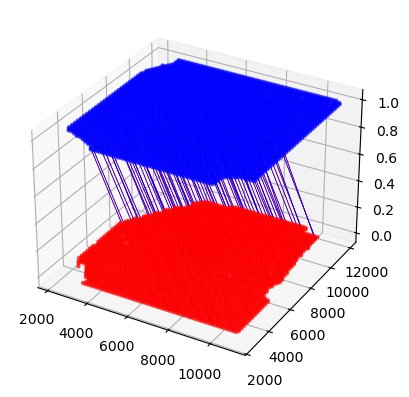

In [6]:


L_sig, L_full, indices_A_matched, indices_B_matched= _recoverfull_new_new_knn.generate_binary_matching(sliceA, downsampled_sliceA, sliceB, downsampled_sliceB, P_1, cutoff_GW_standard, 0.1, SAVE_DIR)


_plot.plot_3d(sliceA.obsm['spatial'], sliceB.obsm['spatial'], L_sig, indices_A_matched, indices_B_matched, linewidth=0.5)

In [7]:
# np.save(f"align_data/{pair}_indices_A_matched.npy", indices_A_matched)
# np.save(f"align_data/{pair}_indices_B_matched.npy", indices_A_matched)

# np.save(f"align_data/{pair}_one_one_downsample_alignment_matrix.npy", L_sig)

In [8]:
###knn recover full

In [9]:
import pandas as pd

thresh_CCC_list = {0.2}

thresh_CGW_list = {250}



M_full = np.array( pd.read_csv(f"/Users/salovjade/Library/CloudStorage/Dropbox/RAFTUP_after0320/DLPFC12/download_from_remote_server/feature_{pair}_not_normalized.csv", header=None) )
test_label_full = np.concatenate((np.array(sliceA.obs['original_clusters']),np.array(sliceB.obs['original_clusters'])),axis=0)
XA_full = sliceA.obsm['spatial']
XB_full = sliceB.obsm['spatial']

for thresh_CCC in thresh_CCC_list:
    for thresh_CGW in thresh_CGW_list:
        print(f"Running alignment for section pair")
        P_full_knn = _recoverfull_new_new_knn.recover_full_mapping_knn(
            M = M_full,
            X1 = sliceA.obsm['spatial'],
            X2 = sliceB.obsm['spatial'],
            P  = L_sig,
            idx1 = indices_A_matched,
            idx2 = indices_B_matched,
            k1 = 4,         # sliceA 侧用的锚点邻域
            k2 = 4,         # sliceB 侧用的锚点邻域
            thresh_CGW=thresh_CGW, 
            thresh_CCC=thresh_CCC, 
            eps=0.01
        )
        P_full_dense_knn = P_full_knn.toarray()

        full_dela_raftup_LAA = _metrics_two_gpr.cal_layer_based_alignment_result_full_skip_all_zero(P_full_dense_knn, test_label_full)
        full_dela_raftup_GPR_300= _metrics_two_gpr.GPR_original(P_full_dense_knn , XA_full, XB_full, dis_cut=300, P_cut=1e-19)
        full_dela_raftup_GPR_600= _metrics_two_gpr.GPR_original(P_full_dense_knn , XA_full, XB_full, dis_cut=600, P_cut=1e-19)
        full_dela_raftup_GPR_900= _metrics_two_gpr.GPR_original(P_full_dense_knn , XA_full, XB_full, dis_cut=900, P_cut=1e-19)

        print("thresh CCC is:", thresh_CCC )
        print("thresh CGW is:", thresh_CGW )
        print("transported mass:", P_full_dense_knn.sum())
        print("full_dela_raftup_LAA:", full_dela_raftup_LAA[0])

        print("full_dela_raftup_GPR_300:", full_dela_raftup_GPR_300)
        print("full_dela_raftup_GPR_600:", full_dela_raftup_GPR_600)
        print("full_dela_raftup_GPR_900:", full_dela_raftup_GPR_900)
        np.save(f'align_data/full_matching_{pair}_{thresh_CGW}_{thresh_CCC}_0108_copycopy_ultile_mvc.npy',P_full_dense_knn)

Running alignment for section pair


recover_full_mapping_knn:  62%|██████▎   | 5/8 [02:53<01:57, 39.18s/it]

Number of blocked positions in recover_full sOT (kNN): 20944228
Number of possible aligned positions (kNN): 32000


Number of iterations in unot: 20001, final error: 9.52e-06
0.7677179962894248 0.22263450834879406 0.0022263450834879408 0.0 0.0 0.0 0.0074211502782931356
thresh CCC is: 0.2
thresh CGW is: 250
transported mass: 0.5386739694140209
full_dela_raftup_LAA: 0.7677179962894248
full_dela_raftup_GPR_300: 0.7735636379534786
full_dela_raftup_GPR_600: 0.8462681215577404
full_dela_raftup_GPR_900: 0.8940846391540483


In [11]:
suffix = "0809"

P_full_paste = np.load(f"/Users/salovjade/Library/CloudStorage/Dropbox/RAFTUP_after0320/raftup_DLPFC_DONE/save_all_methods_spacel_staligner_paste_raftup/combine_paste/alignment_matrix_{suffix}.npy")

In [12]:
full_paste_LAA = _metrics_two_gpr.cal_layer_based_alignment_result_full_skip_all_zero(P_full_paste, test_label_full)
full_paste_GPR_300= _metrics_two_gpr.GPR_original(P_full_paste, XA_full, XB_full, dis_cut=300, P_cut=1e-12)
full_paste_GPR_600= _metrics_two_gpr.GPR_original(P_full_paste, XA_full, XB_full, dis_cut=600, P_cut=1e-12)
full_paste_GPR_900= _metrics_two_gpr.GPR_original(P_full_paste, XA_full, XB_full, dis_cut=900, P_cut=1e-12)

print("full_paste_LAA):", full_paste_LAA [0])

print("full_paste_GPR_300):", full_paste_GPR_300)
print("full_paste_GPR_600):", full_paste_GPR_600)
print("full_paste_GPR_900):", full_paste_GPR_900)

0.22072586167541658 0.40629993152248345 0.34855055923305184 0.0038803926044282126 0.0 0.0 0.02054325496461995
full_paste_LAA): 0.22072586167541658
full_paste_GPR_300): 0.6794119890809263
full_paste_GPR_600): 0.7756635817174383
full_paste_GPR_900): 0.8277135280644361
